# Comparing Constitutions

## Objective

To explore methods for measuring the semantic similarity of pairs of constitutions.

For example, are constitutions with neoliberal features more similar to one another than they are to constitutions with a more social deomocratic character.



## Initialise

In [1]:
__author__      = 'Roy Gardner'
__copyright__   = 'Copyright 2023-2024, Roy and Sally Gardner'

%run ./_library/packages.py
%run ./_library/utilities.py
%run ./_library/mapping.py
%run ./_library/kde_pdf.py

model_path = '../model/'

try:
    n = len(model_dict)
except:
    model_dict = do_load(model_path,exclusion_list=[],verbose=True)


Loading model…
Finished loading model.


## PDF-based analysis

Looks at the semantic similarity of pairs of constitutions.

The analysis is based on a similarity matrix where the sections of all constitutions are in both rows and columns. Cell values contain the semantic similarity score for a pair of sections. 

For each constitution pairing:

- For the first constitution in the pair collect the **row** indices from the similarity matrix correponding to the constitution's sections.
- For the second constitution in the pair collect the **column** indices from the similarity matrix correponding to the constitution's sections.
- Use the row and column indices to extract a sub-matrix from the similarity matrix.
- Extract the maximum similarity values from the sub-matrix as follows:
    - A first pass collects the row and column indices of the maximum value in rows.
    - A second pass transposes the matrix to find the maximum values for original matrix columns (rows in the transposed matrix) not captured in the first pass.
    - The rationale is that a row segment A may be maximally similar to a column segment B, but B might not be maximally similar to A
- Use the maximum similarity values to generate a probability density function (PDF) using Kernel Density Estimation (KDE). Rationale:
    - The more similar a pair of constitutions the longer and denser the right-hand tail of the distribution. This can be verified using test documents.
- Integrate under the PDF in a given similarity score interval (default 0.8 - 1.0) to measure the likelihood that a pair of constitutions contain semantically similar sections.
- Visualise the PDFs and the integral values.


[('Chile_2021', '1980'), ('Ecuador_2021', '2008'), ('Bolivia_2009', '2009'), ('Chile_2018D', '2018'), ('Chile_2022D', '2022'), ('Chile_2023DD', '2023')]
(('Chile_2021', '1980'), ('Ecuador_2021', '2008'))
(1011, 1686)
(('Chile_2021', '1980'), ('Bolivia_2009', '2009'))
(1011, 1413)
(('Chile_2021', '1980'), ('Chile_2018D', '2018'))
(1011, 667)
(('Chile_2021', '1980'), ('Chile_2022D', '2022'))
(1011, 1418)
(('Chile_2021', '1980'), ('Chile_2023DD', '2023'))
(1011, 1117)
(('Ecuador_2021', '2008'), ('Bolivia_2009', '2009'))
(1686, 1413)
(('Ecuador_2021', '2008'), ('Chile_2018D', '2018'))
(1686, 667)
(('Ecuador_2021', '2008'), ('Chile_2022D', '2022'))
(1686, 1418)
(('Ecuador_2021', '2008'), ('Chile_2023DD', '2023'))
(1686, 1117)
(('Bolivia_2009', '2009'), ('Chile_2018D', '2018'))
(1413, 667)
(('Bolivia_2009', '2009'), ('Chile_2022D', '2022'))
(1413, 1418)
(('Bolivia_2009', '2009'), ('Chile_2023DD', '2023'))
(1413, 1117)
(('Chile_2018D', '2018'), ('Chile_2022D', '2022'))
(667, 1418)
(('Chile_20

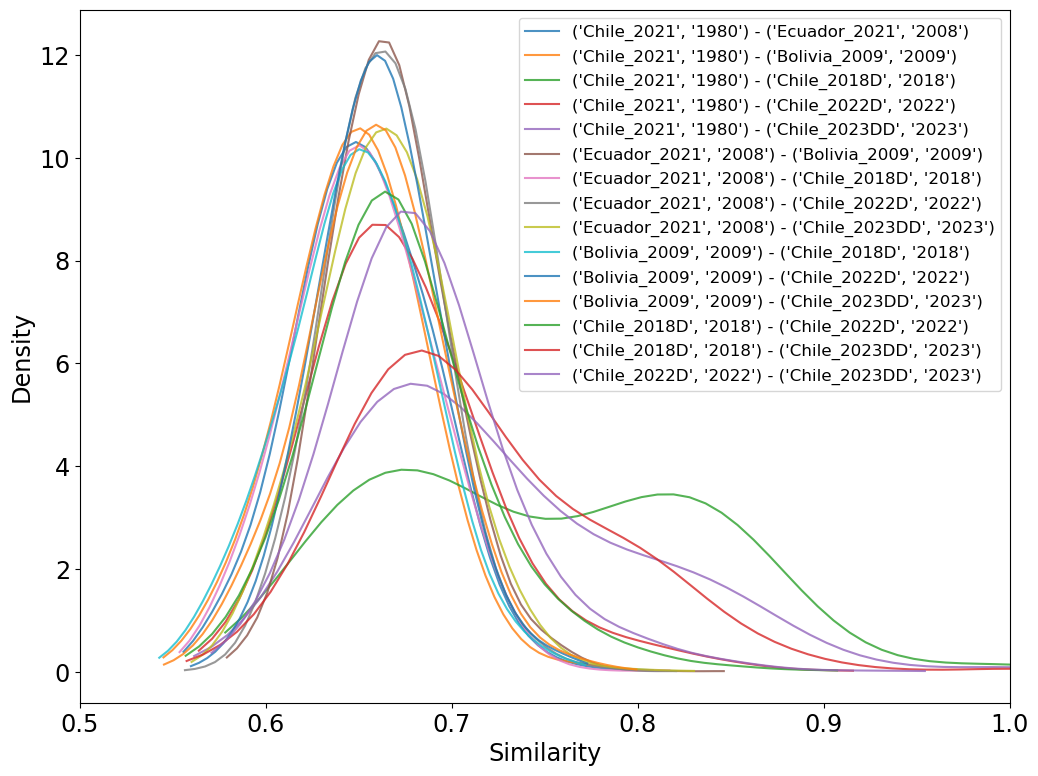


Relative magnitude of integrals in interval 0.8 - 1.0 for pairs of constitutions.


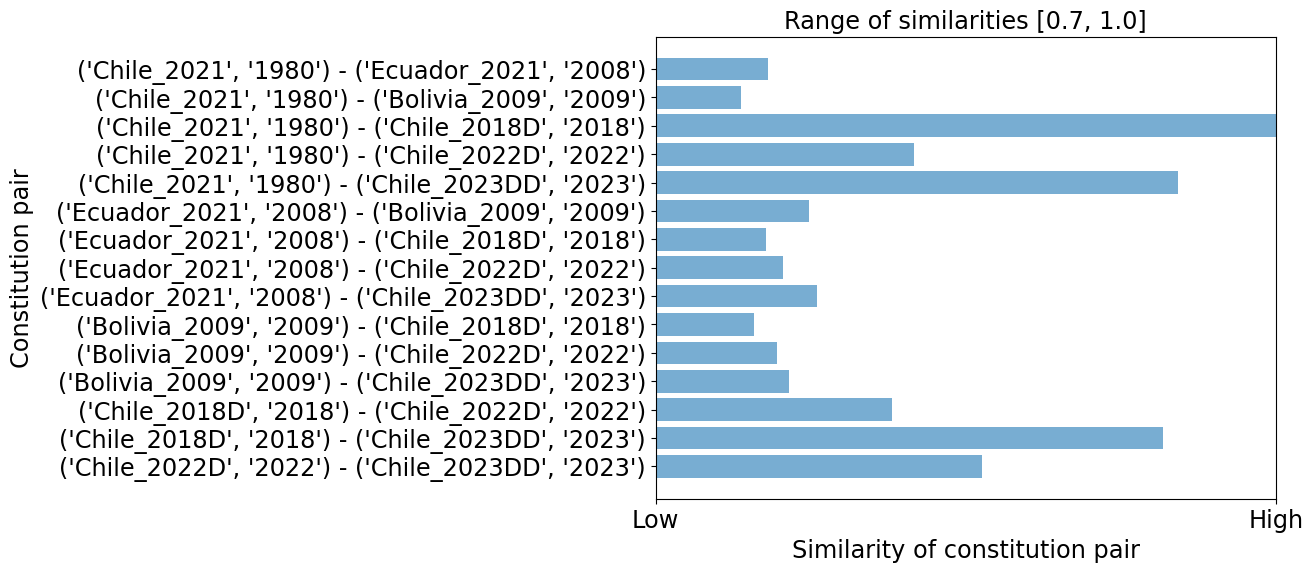

In [2]:

documents_dict = model_dict['documents_dict']
segments_dict = model_dict['segments_dict']
encoded = model_dict['encoded_segments']
segments_matrix = np.array(model_dict['segments_matrix'])

doc_data = [(k,v['date']) for k,v in documents_dict.items()]
doc_data = sorted(doc_data,key=lambda t:t[1])
print(doc_data)

samples_list = []
labels_list = []

combs = combinations(doc_data,r=2)
for c in combs:
    row_doc = c[0][0]
    col_doc = c[1][0]
    
    row_segment_ids = [k for k,_ in segments_dict.items() if k.split('/')[0] == row_doc and\
                             k in encoded]
    row_segment_indices = [encoded.index(segment_id) for segment_id in row_segment_ids]
    
    col_segment_ids = [k for k,_ in segments_dict.items() if k.split('/')[0] == col_doc and\
                             k in encoded]
    col_segment_indices = [encoded.index(segment_id) for segment_id in col_segment_ids]
        
    # Get the segments sub-matrix for the pair of documents
    matrix = segments_matrix[np.ix_(row_segment_indices,col_segment_indices)]
    samples_list.append(get_max_scores(matrix))
    labels_list.append(str(c[0]) + ' - ' + str(c[1]))

print()
print('PDFs for pairs of constitutions from the set - see legend.')
plot_pdfs(samples_list,labels_list,xlim=[0.5,1.0])

limits = [0.7,1.0]

integrals = get_pdf_integrals(samples_list,limits,sample_size=2)
print()
print('Relative magnitude of integrals in interval 0.8 - 1.0 for pairs of constitutions.')
plot_pdf_integrals(integrals,labels_list,limits,'Similarity of constitution pair','Constitution pair',\
                   title_suffix='',figsize=(8,6))


## Distribution of sections over topics

Given recent analysis of ontology workbench outputs, and segments-as-topics, there are questions around the value of the following analysis.

In this section the the distribution of sections over CCP topics is measured for each of the four constitutions at a semantic threshold value. In other words, we find the number of at or above threshold sections for each topic.

Pearsons R is used to measure the correlation between pairs of constitutions (see below the graph). All correlations are high and highly significant, The pairs with the highest correlations are:

- The in-force constitution and the Bachelet draft
- The in-force constitution and the 2023 draft

This is consistent with the PDF-based analysis above.




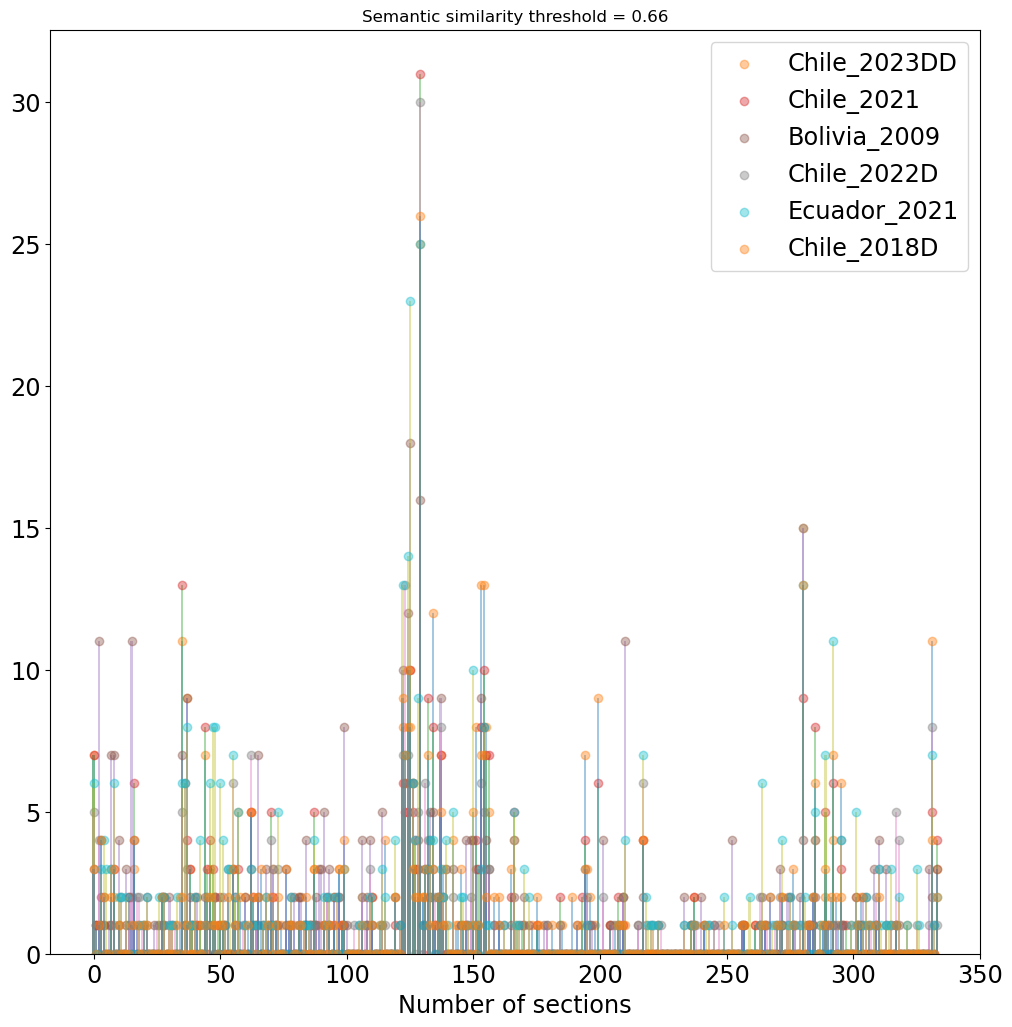

Chile_2021-Chile_2018D PearsonRResult(statistic=0.8401871916134817, pvalue=3.0390884050163724e-90)
Chile_2021-Chile_2022D PearsonRResult(statistic=0.7923220008881877, pvalue=3.127937764293108e-73)
Chile_2021-Chile_2023DD PearsonRResult(statistic=0.8659284137025633, pvalue=6.450535260743904e-102)
Chile_2018D-Chile_2022D PearsonRResult(statistic=0.8368205586006044, pvalue=7.167994943638946e-89)
Chile_2018D-Chile_2023DD PearsonRResult(statistic=0.766425897747856, pvalue=8.550741185000672e-66)
Chile_2022D-Chile_2023DD PearsonRResult(statistic=0.7908264345394082, pvalue=8.978349518895807e-73)


In [3]:
encoded = model_dict['encoded_segments']
doc_ids = set([sid.split('/')[0] for sid in encoded])

threshold = 0.66

topic_ids = model_dict['encoded_topics']
    
topic_dict = {}
for did in doc_ids:
    y = []
    for i,row in enumerate(model_dict['topic_segment_matrix']):
        y.append(len([j for j,v in enumerate(row) if v >= threshold and\
                                          encoded[j].split('/')[0]==did]))
    topic_dict[did] = y

x = range(0,len(topic_ids))
fig = plt.figure(figsize=(12,12))
for did,y in topic_dict.items():
    plt.bar(x,y,alpha=0.4)
    plt.scatter(x,y,alpha=0.4,label=did)
plt.xticks(fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.xlabel('Topic index',fontsize='xx-large')
plt.xlabel('Number of sections',fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.title('Semantic similarity threshold = 0.66')
plt.show()

print('Chile_2021-Chile_2018D',stats.pearsonr(topic_dict['Chile_2021'],topic_dict['Chile_2018D']))
print('Chile_2021-Chile_2022D',stats.pearsonr(topic_dict['Chile_2021'],topic_dict['Chile_2022D']))
print('Chile_2021-Chile_2023DD',stats.pearsonr(topic_dict['Chile_2021'],topic_dict['Chile_2023DD']))
print('Chile_2018D-Chile_2022D',stats.pearsonr(topic_dict['Chile_2018D'],topic_dict['Chile_2022D']))
print('Chile_2018D-Chile_2023DD',stats.pearsonr(topic_dict['Chile_2018D'],topic_dict['Chile_2023DD']))
print('Chile_2022D-Chile_2023DD',stats.pearsonr(topic_dict['Chile_2022D'],topic_dict['Chile_2023DD']))



## Topic scoring topics from the distributions

In [ ]:
from scipy.signal import find_peaks

print()

order = ['Chile_2021','Chile_2018D','Chile_2022D','Chile_2023DD','Bolivia_2009','Ecuador_2021']

for k in order:
    print(k)

    p = find_peaks(topic_dict[k],height=10)
    z = list(zip(list(p[0]),list(p[1]['peak_heights'])))
    z = sorted(z,key=lambda t:t[1],reverse=True)
    for t in z[0:6]:
        print('\t',topic_ids[t[0]])
    print()
